## cartopy 更换底图
#https://stackoverflow.com/questions/67508054/improve-resolution-of-cartopy-map
#etopo https://www.ngdc.noaa.gov/mgg/global/global.html
将图放进cartopy文件夹下面C:\D\software\anaconda\anaconda_install\envs\hydrogr\Lib\site-packages\cartopy\data\raster\natural_earth
并且修改image.josn文件  
{"__comment__": "JSON file specifying the image to use for a given type/name and resolution. Read in by cartopy.mpl.geoaxes.read_user_background_images.",
  "BM": {
    "__comment__": "Blue Marble Next Generation, July ",
    "__source__": "https://neo.sci.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG-TB",
    "__projection__": "PlateCarree",
    "low": "bluemarble1degrees.jpeg",
    "high": "bluemarble01degrees.jpeg"}, #注意这个逗号，下面为etopo的脚本
  "ETOPO": {
    "__comment__": "ETOPO",
    "__source__": "https://www.ngdc.noaa.gov/mgg/global/global.html",
    "__projection__": "PlateCarree",
    "high": "color_etopo1_ice_low.jpg"}
}
在调用底图时候：
ax.background_img(name='ETOPO', resolution='high')

下图是geopandas和cartopy联合使用，关键点：
1 geopandas和cartopy必须得再一个projection
fig, ax = plt.subplots(figsize=(18, 12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-120,)})
2 在绘制经纬度时候
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection=ccrs.PlateCarree(central_longitude=-120,))
[0.1, 0.1, 0.9, 0.9]控制axes图幅与fig

In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.image import imread
## Add COASTLINE, rivers and lakes
# fig = plt.figure()
fig, ax = plt.subplots(figsize=(18, 12),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-120,)})
# [-128,   23,  -65,   55]
leftlon, rightlon, lowerlat, upperlat = (-125, -65, 23, 55)
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9], projection=ccrs.PlateCarree(central_longitude=-120,))
ax.set_extent([-125, -65, 23, 55], ccrs.Geodetic())
wbd_path=r'C:\Users\dingxj\Desktop\WBD\WBDHU2t.shp'
wbd_path=gpd.read_file(wbd_path)
ax = wbd_path.geometry.to_crs("EPSG:4326").plot(ax=ax,
                                                facecolor="none",#这句话是让仅画出shp
#                                              facecolor='grey',
#                                                 column='shape_Area',
#                                                 cmap='Reds',
#                                                 scheme='NaturalBreaks',
#                                                  k=5,
                                             edgecolor='k',
                                             alpha=0.8)



#https://stackoverflow.com/questions/67508054/improve-resolution-of-cartopy-map
#加载底图
ax.background_img(name='ETOPO', resolution='high')
ax.add_feature(cfeature.RIVERS.with_scale('50m'))
ax.add_feature(cfeature.LAKES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))
ax.add_feature(cfeature.BORDERS, linestyle=':',linewidth=2)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1.2, color='k',
                  alpha=0.5, linestyle='--')
gl.top_labels = False  # 关闭顶端的经纬度标签
# gl.right_labels=False# 关闭右侧的经纬度标签

gl.xformatter = LONGITUDE_FORMATTER  # x轴设为经度的格式
gl.yformatter = LATITUDE_FORMATTER  # y轴设为纬度的格式
gl.xlocator = mticker.FixedLocator(np.arange(leftlon,rightlon+10,10))
gl.ylocator = mticker.FixedLocator(np.arange(lowerlat,upperlat+10,5))
gl.xlabel_style = {'size': 30, 'color': 'black'}
gl.ylabel_style = {'size': 30, 'color': 'black'}
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.show()

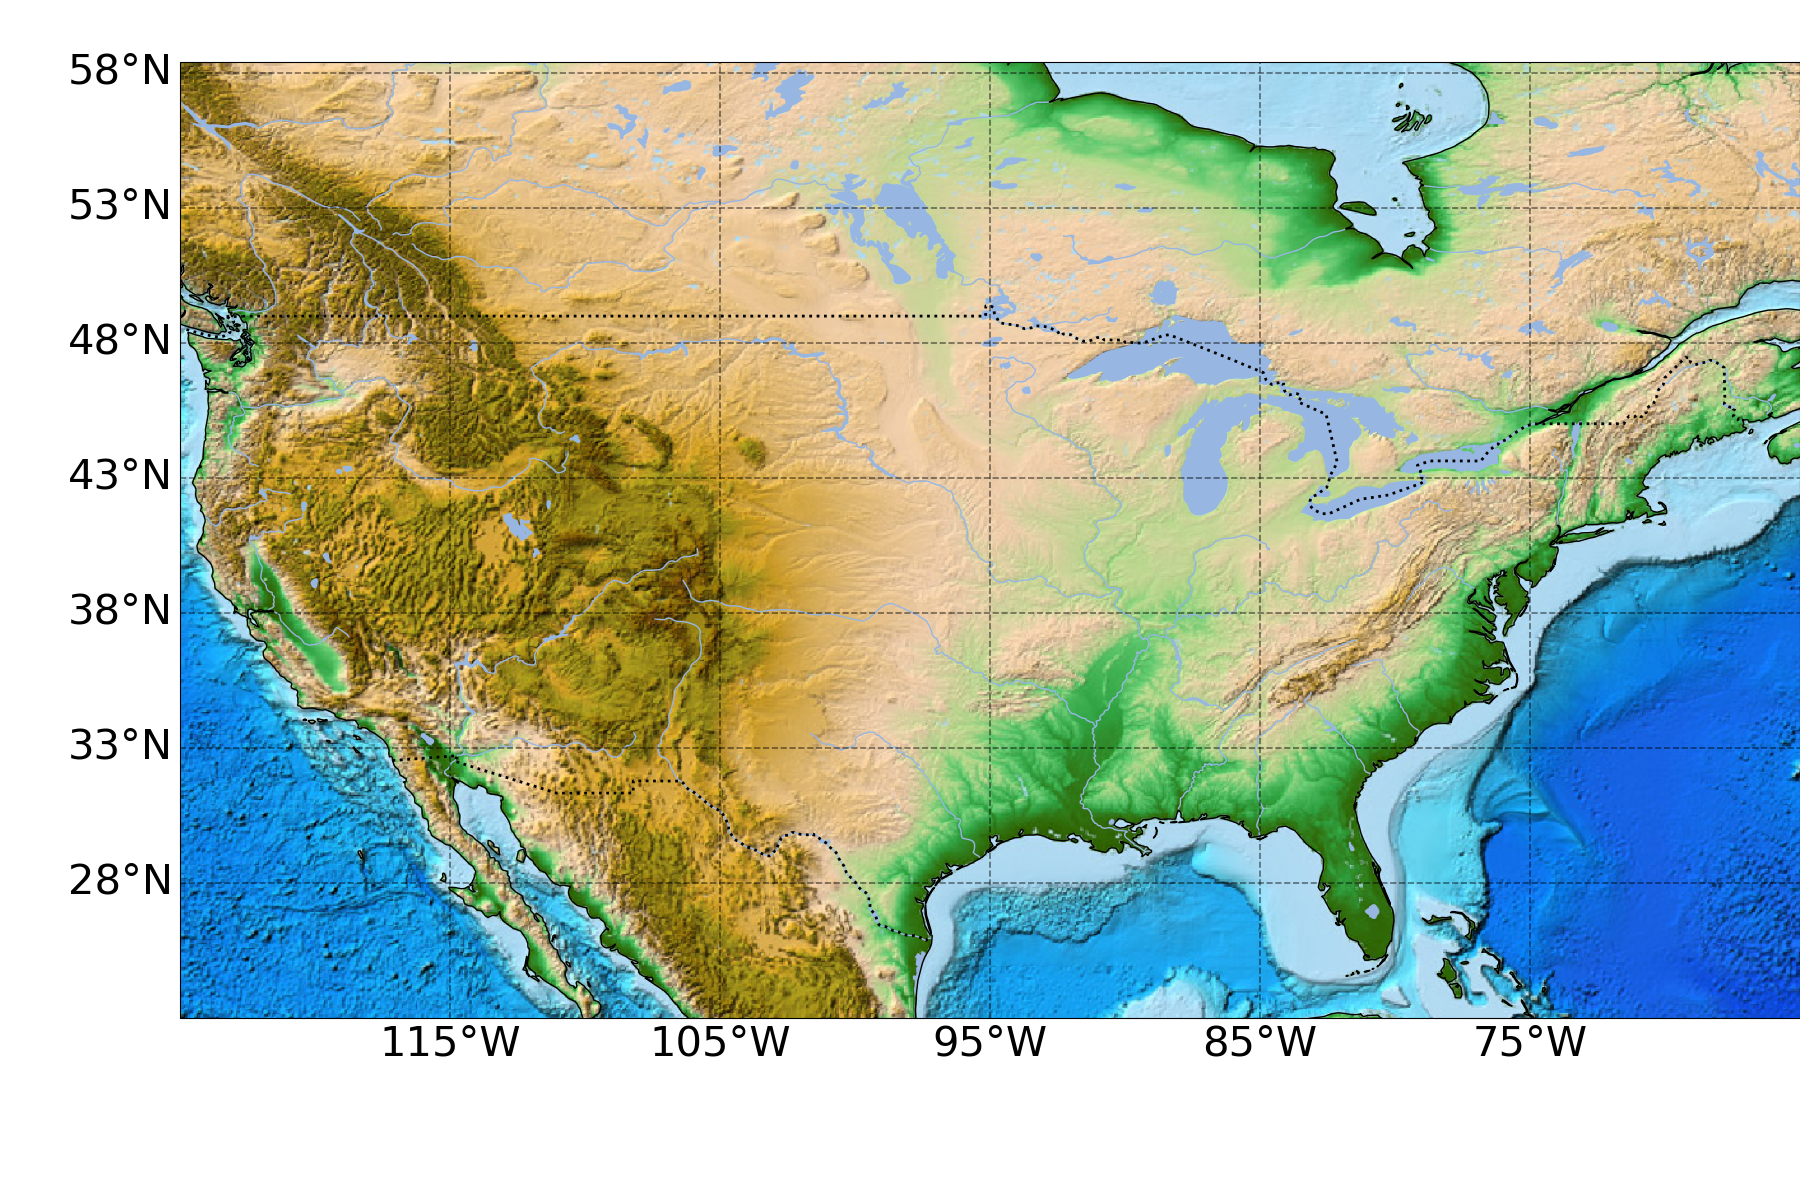

## 关于mask,这里加载了包regionmask
regionmask将shp geodataframe和经纬度大小传入就可以生成指定区域的mask
用到numpy mesh  np.meshgrid()生成mask对应的经纬度，再用pcolormesh绘图
下面datamask是将shp面的给蒙掉
mask是jiang

<ipython-input-2-7eb7b728a73c>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_mask = np.isnan(_ma).astype(np.float)
<ipython-input-2-7eb7b728a73c>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,data_mask , zorder = 5)#边上mask


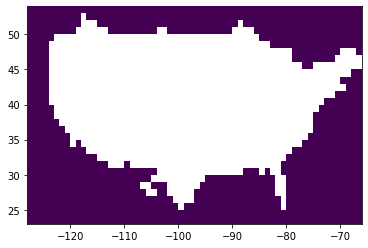

In [2]:
import numpy as np
import cartopy
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
WBD_shp=r'C:\Users\dingxj\Desktop\WBD\WBDHU2t.shp'
shp=gpd.read_file(WBD_shp)
array=[-128,   23,  -65,   55]
xlim=(array[0],array[2])
lon=np.arange(-128,-65)
ylim=(array[1],array[3])
lat=np.arange(23,55)
mask=regionmask.mask_geopandas(shp,lon,lat)

_ma =mask.values

data_mask = np.isnan(_ma).astype(np.float)
data_mask[data_mask == 0] = np.nan

X , Y  = np.meshgrid(mask.lon,mask.lat)
# plt.pcolormesh(X,Y,mask ,  zorder = 1)#中间mask
plt.pcolormesh(X,Y,data_mask , zorder = 5)#边上mask
plt.show()

<ipython-input-3-1094472a8c66>:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_mask = np.isnan(_ma).astype(np.float)
<ipython-input-3-1094472a8c66>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,mask ,  zorder = 1)#中间mask


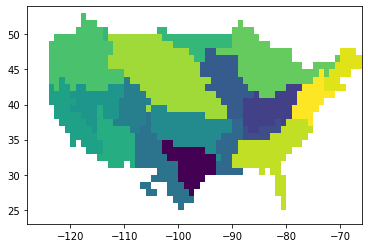

In [3]:
import numpy as np
import cartopy
import geopandas as gpd
import regionmask
import matplotlib.pyplot as plt
WBD_shp=r'C:\Users\dingxj\Desktop\WBD\WBDHU2t.shp'
shp=gpd.read_file(WBD_shp)
array=[-128,   23,  -65,   55]
xlim=(array[0],array[2])
lon=np.arange(-128,-65)
ylim=(array[1],array[3])
lat=np.arange(23,55)
mask=regionmask.mask_geopandas(shp,lon,lat)

_ma =mask.values

data_mask = np.isnan(_ma).astype(np.float)
data_mask[data_mask == 0] = np.nan

X , Y  = np.meshgrid(mask.lon,mask.lat)
plt.pcolormesh(X,Y,mask ,  zorder = 1)#中间mask
# plt.pcolormesh(X,Y,data_mask , zorder = 5)#边上mask
plt.show()

In [ ]:
##geopandas添加在线地图
#https://researchworkspace.com/file/6585554/routes-usgstiles-contextmap.ipynb
#ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldTopoMap)
#ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
#ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

#ctx.add_basemap(ax, source=ctx.providers.OpenTopoMap)
#ctx.add_basemap(ax, source='https://a.tile.opentopomap.org/{z}/{x}/{y}.png')

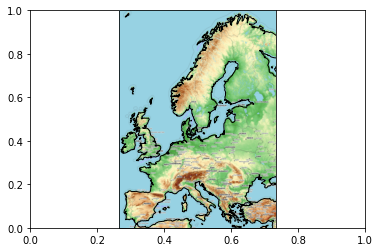

In [7]:
import matplotlib.pyplot as plt
import cartopy
import contextily
import contextily as ctx
# contextily & cartopy
fig, ax = plt.subplots()
ax = plt.axes(projection=cartopy.crs.Mercator())
ax.add_feature(cartopy.feature.COASTLINE)
ax.set_extent([-11,37,35,70])
# contextily.add_basemap(ax, source=contextily.providers.Esri.WorldTopoMap)
contextily.add_basemap(ax, source='https://a.tile.opentopomap.org/{z}/{x}/{y}.png')

## geopandas添加在线底图

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import contextily as ctx
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import adjustText as aT
wbd_path=r'C:\Users\dingxj\Desktop\WBD\WBDHU2t.shp'
wbd_path=gpd.read_file(wbd_path)
data_pth=r'C:\Users\dingxj\Desktop\HCDN\hydro_hcdn_810_monthly_climate_forcing\hydro_hcdn_810\comp\Selected_HCDN_stations\selected_HCDN_withsnowmelt.csv'
fig, ax = plt.subplots(figsize=(18, 12))
# ax.set_extent([-100, 30, 0, 80], crs=ccrs.PlateCarree())
# array=[-124.725839,   24.498131,  -66.949895,   49.384358]
array=[-128,   23,  -65,   55]
xlim=(array[0],array[2])
ylim=(array[1],array[3])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax = wbd_path.geometry.to_crs("EPSG:4326").plot(ax=ax,
                                                facecolor="none",
#                                              facecolor='grey',
#                                                 column='shape_Area',
#                                                 cmap='Reds',
#                                                 scheme='NaturalBreaks',
#                                                  k=5,
                                             edgecolor='k',
                                             alpha=0.8)
#geoscater plot of HCDN basin
#all guage location
#数据顺序，首先绘制所有HCDN,再绘制0.4，再绘制大于0.5以上
df=pd.read_csv(data_pth)
df1=df[df['snow factor index']>0.4]
df2=df[df['snow factor index']>0.5]

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long_dd, df.lat_dd))
gdf.plot(ax=ax, color='white')

gdf1= gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.long_dd, df1.lat_dd))
gdf1.plot(ax=ax, color='deepskyblue')

gdf2= gpd.GeoDataFrame(
    df2, geometry=gpd.points_from_xy(df2.long_dd, df2.lat_dd))
gdf2.plot(ax=ax, color='indigo')
#plot text
texts=[]
# for x,y,label in zip(wbd_path.geometry.representative_point().x,
#                      wbd_path.geometry.representative_point().y,wbd_path['name']):
#     texts.append(plt.text(x, y, label, fontsize = 8))
for x,y,label in zip(wbd_path.geometry.representative_point().x,
                     wbd_path.geometry.representative_point().y,wbd_path['name']):
    texts.append(ax.text(x, y, label,ha="center", va="center", fontsize = 8))
aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1),
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
ctx.add_basemap(ax,
               crs="EPSG:4326",
               # source=ctx.providers.CartoDB.Voyager
                source=ctx.providers.OpenTopoMap
              )
plt.show()

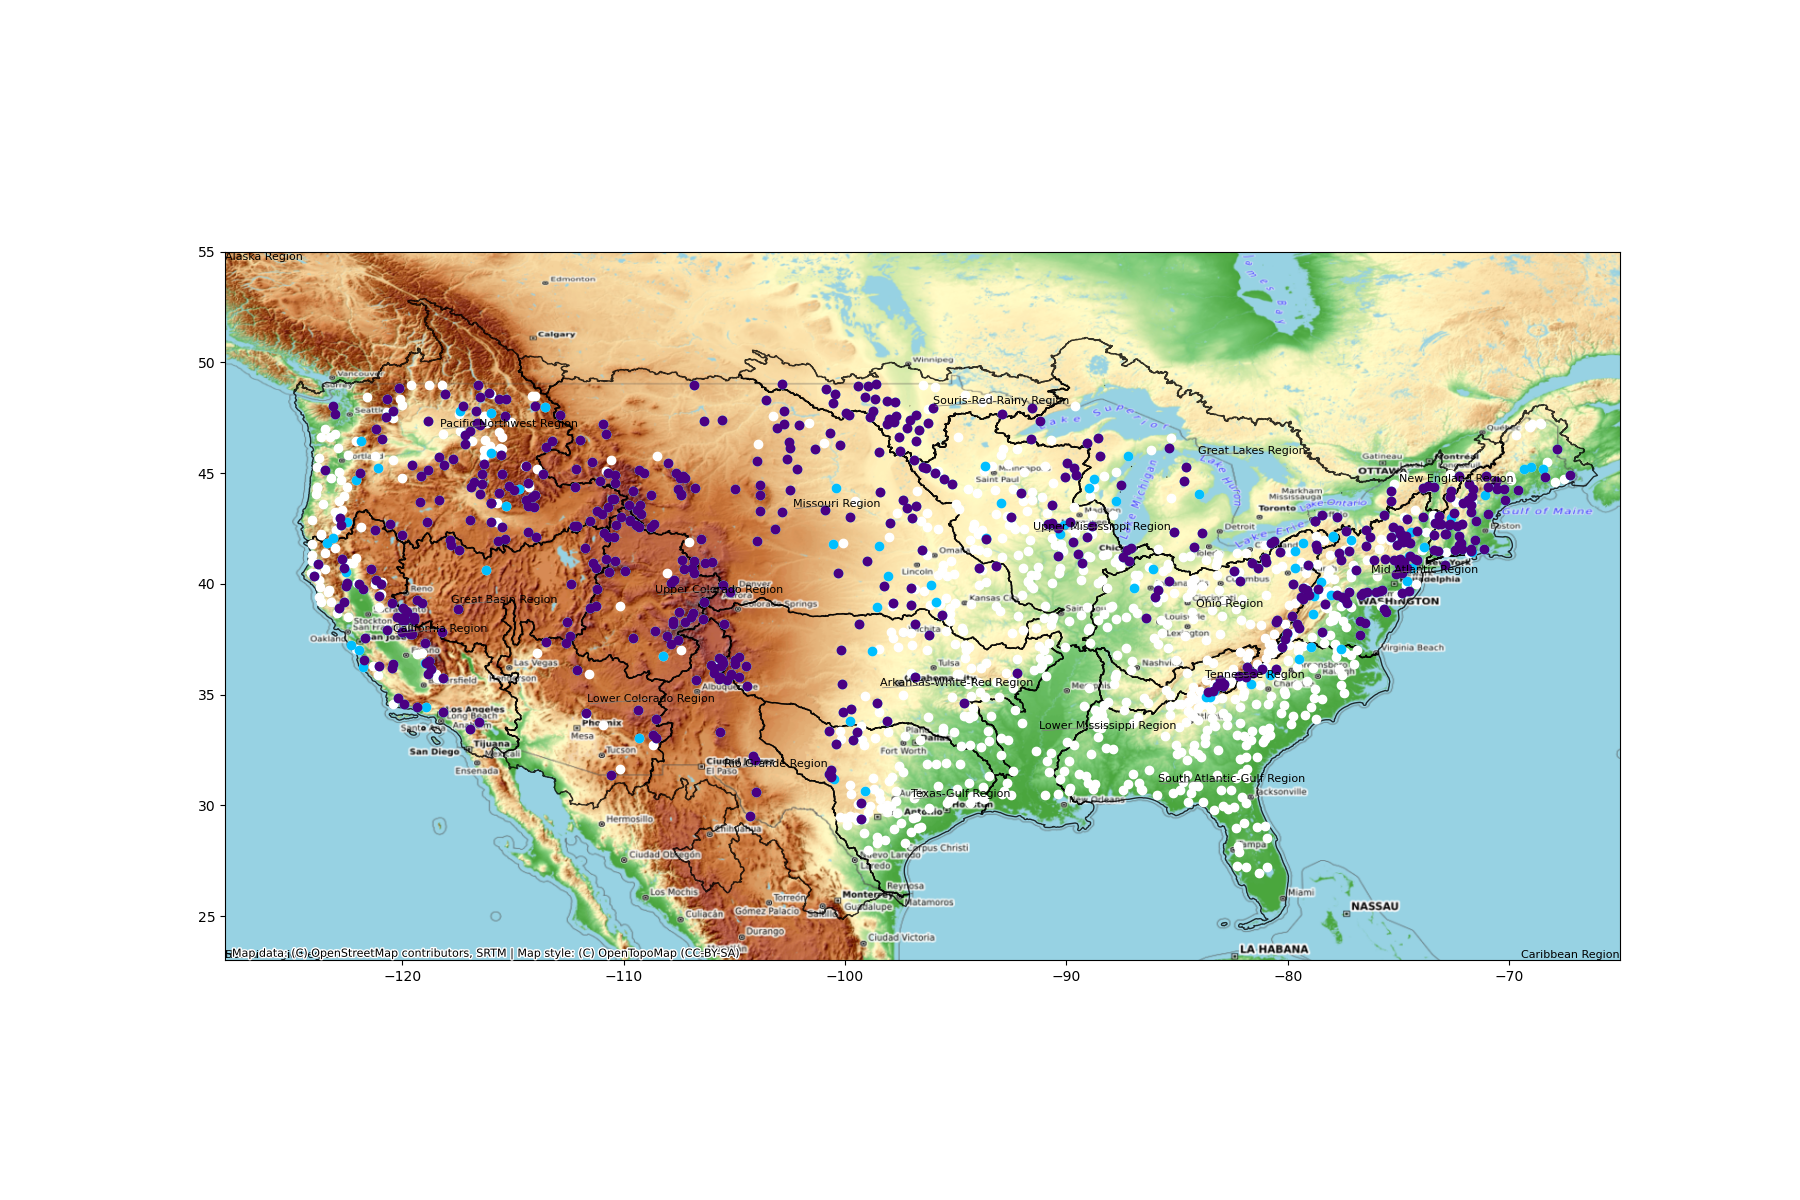